#Importing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import glob
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from google.colab.patches import cv2_imshow
import torch.nn.functional as F
import cv2
from torch.nn.functional import relu
from tqdm import tqdm
import random
from torch.utils.data import Subset

#Data

##unzip files

In [3]:
# import zipfile
# Test_path = "/content/drive/MyDrive/D.L./HW3/TEST.zip"
# destination_path = "/content/drive/MyDrive/D.L./HW3/"
# zip_file = zipfile.ZipFile(Test_path, 'r')
# zip_file.extractall(destination_path)
# zip_file.close()

In [4]:
# Train_Val_path = "/content/drive/MyDrive/D.L./HW3/train_val.zip"
# destination_path = "/content/drive/MyDrive/D.L./HW3/"
# zip_file = zipfile.ZipFile(Train_Val_path, 'r')
# zip_file.extractall(destination_path)
# zip_file.close()

##Data set generator

In [5]:
class Dataset_generator(torch.utils.data.Dataset):
    def __init__(self, image_files, mask_files, transform1,transform2 ):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):

        #open image and mask
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = Image.open(image_path)
        mask_3ch = Image.open(mask_path)

        #convert to tensor and resize images and masks
        image = self.transform1(image)
        mask_3ch = self.transform1(mask_3ch)

        #reshape mask
        mask_3ch = mask_3ch.permute(1, 2, 0)

        #convert mask to numpy
        mask_3ch = np.array(mask_3ch)


        #create function to create 8 chanels for masks
        def convert_3ch_to_8ch(mask):
            # colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0), (255, 255, 255)]
            colors = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 1), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
            # colors_names = ["BW","RO", "PF", "HD", "WR", "RI", "FV", "SR"]
            height, width, _ = mask.shape
            num_classes = len(colors)
            new_mask = np.zeros((height, width, num_classes), dtype=np.uint8)
            for i in range(height):
                for j in range(width):
                    color = tuple(np.round(mask[i, j]))
                    if color in colors:
                        class_index = colors.index(color)
                        new_mask[i, j, class_index] = 1
            return new_mask

        #convert masks to 8 chanel images from 3 chanel image
        mask_8ch = convert_3ch_to_8ch(mask_3ch)

        #convert mask to tensor
        mask_8ch = torch.Tensor(mask_8ch)


        #normalized iamge
        image = self.transform2(image)

        # rotate and flip masks to match with images
        # mask_8ch = torch.rot90(mask_8ch, 1, [0, 1])
        # mask_8ch = torch.flip(mask_8ch, [0])



        #Data augmention with 30% probability
        num = random.uniform(0, 1)
        if num < 0.3:

          num2 = random.uniform(0, 1)

          if num2 <= 0.4:
            num3 = random.uniform(0, 1)
            if num3 < 0.5:
              image = torch.flip(image, dims = [0])
              mask_8ch = torch.flip(mask_8ch, dims = [1])
            else:
              image = torch.flip(image, dims = [1])
              mask_8ch = torch.flip(mask_8ch, dims = [0])

          elif 0.4 < num2 <= 0.8:
              shift_amount = random.randint(-200, 200)
              num4 = random.uniform(0, 1)

              if num4 < 0.5:
                image = torch.roll(image, shifts=shift_amount, dims=1)
                mask_8ch = torch.roll(mask_8ch, shifts=shift_amount, dims=0)
              else:
                image = torch.roll(image, shifts=shift_amount, dims=0)
                mask_8ch = torch.roll(mask_8ch, shifts=shift_amount, dims=1)

          else:
              image = torch.rot90(image, 2, [0, 1])
              mask_8ch = torch.rot90(mask_8ch, 2, [0, 1])


        return image, mask_8ch



##Train , Validation DataSet

In [6]:
#File pathes
Train_Val_images = "/content/drive/MyDrive/D.L./HW3/train_val/images"
Train_Val_labels = "/content/drive/MyDrive/D.L./HW3/train_val/masks"

In [7]:
#split data to train and validation data in balanced way

start_letters = ['d','f','n','w']
train_images = []
train_labels = []
val_images = []
val_labels = []

for i in start_letters:
  search_images = os.path.join(Train_Val_images, f'{i}*')
  search_masks = os.path.join(Train_Val_labels, f'{i}*')


  image = glob.glob(search_images)
  mask = glob.glob(search_masks)
  image.sort()
  mask.sort()

  train_i, val_i, train_m, val_m = train_test_split(image, mask, test_size=0.1, shuffle=True)

  train_images = train_images + train_i
  train_labels = train_labels + train_m
  val_images = val_images + val_i
  val_labels = val_labels + val_m

In [8]:
#Define transformers dor use in Dataset_generator function
transform1 = Compose([Resize((160, 160)),ToTensor()])

mean = [0.2, 0.2, 0.2]
std = [0.5, 0.5, 0.5]
transform2 = transforms.Compose([transforms.Normalize(mean, std)])

In [9]:
#Use Dataset_generator to create train and validation dataset
train_dataset = Dataset_generator(train_images, train_labels, transform1=transform1, transform2=transform2)
val_dataset = Dataset_generator(val_images, val_labels, transform1=transform1, transform2=transform2)


#Create Dataloader with batch_size=16 and shuffle=True for train and validate model
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

##Test DataSet

In [12]:
Test_images = "/content/drive/MyDrive/D.L./HW3/TEST/images"
Test_labels = "/content/drive/MyDrive/D.L./HW3/TEST/masks"

In [13]:
test_masks = []
Test_images_bmp = glob.glob(Test_labels + "/*.bmp")

for file in Test_images_bmp:
    test_masks.append(file)

In [14]:
test_image_files = os.listdir(Test_images)
test_images = []
for i in test_image_files:
  test_image = os.path.join(Test_images,i)
  test_images.append(test_image)

In [15]:
test_images.sort()
test_masks.sort()

In [16]:
transform1 = Compose([Resize((160, 160)),ToTensor()])


mean = [0.2, 0.2, 0.2]
std = [0.5, 0.5, 0.5]
transform2 = transforms.Compose([ transforms.Normalize(mean, std)])

In [17]:
test_dataset = Dataset_generator(test_images, test_masks, transform1=transform1, transform2=transform2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_images), shuffle=True)

#model

##create model

In [20]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        #Encoder
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down1 =  nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.down2 =  nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


        self.down3 =  nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.down4 =  nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)

        )

        self.down5 =  nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )



        # Decoder
        self.ConvTranspose1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up1 =  nn.Sequential(
             nn.Conv2d(1024, 512, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
        )



        self.ConvTranspose2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 =  nn.Sequential(
             nn.Conv2d(512, 256, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(256, 256, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
        )

        self.ConvTranspose3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3 =  nn.Sequential(
             nn.Conv2d(256, 128, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(128, 128, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
        )


        self.ConvTranspose4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up4 =  nn.Sequential(
             nn.Conv2d(128, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(64, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
        )


        # Output layer
        self.outconv = nn.Conv2d(64, 8, kernel_size=1)

    def forward(self, x):
        # Encoder
          d1 = self.down1(x)
          d1p = self.maxpool(d1)
          d2 = self.down2(d1p)
          d2p = self.maxpool(d2)
          d3 = self.down3(d2p)
          d3p = self.maxpool(d3)
          d4 = self.down4(d3p)
          d4p = self.maxpool(d4)
          d5 = self.down5(d4p)

          # Decoder
          T1 = self.ConvTranspose1(d5)
          x = torch.cat([T1, d4], dim=1)
          up1 = self.up1(x)

          T2 = self.ConvTranspose2(up1)
          x = torch.cat([T2, d3], dim=1)
          up2 = self.up2(x)

          T3 = self.ConvTranspose3(up2)
          x = torch.cat([T3, d2], dim=1)
          up3 = self.up3(x)

          T4 = self.ConvTranspose4(up3)
          x = torch.cat([T4, d1], dim=1)
          up4 = self.up4(x)


          # Output layer
          out = self.outconv(up4)


          return out

In [21]:
#Built model
model = UNet()

In [22]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
model.to(device)

UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

##train model

In [24]:
def calculate_miou(predictions, targets):
    # Reshape predictions and targets to (N, num_classes, H, W)
    predictions = predictions.view(-1, 8, predictions.size(2), predictions.size(3))
    targets = targets.view(-1, 8, targets.size(2), targets.size(3))

    # Compute intersection
    intersection = torch.sum(predictions * targets, dim=(2, 3))
    # Compute union
    union = torch.sum(predictions + targets, dim=(2, 3)) - intersection

    # Compute IoU
    iou = intersection / (union + 1e-8)  # Add epsilon to avoid division by zero

    # Compute mean IoU
    miou = torch.mean(iou)

    return miou

In [25]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimization function
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum = 0.99)
learning_rate = 0.01
decay = 0.01
momentum = 0.99
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=momentum)

#Epochs
num_epochs = 5

In [26]:
#Lists for collect loss and miou value in each epocch
train_loss_values = []
train_miou_values = []
eval_loss_values = []
eval_miou_values = []



for epoch in range(num_epochs):
    train_loss = 0.0
    train_miou = 0.0

    #Train model
    model.train()
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.permute(0, 3, 1, 2)

        optimizer.zero_grad()

        outputs = model(images)
        # softmax_output = torch.softmax(outputs, dim=1)
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


        train_miou += calculate_miou(outputs, labels)

    train_loss /= len(train_dataloader)
    train_loss_values.append(train_loss)

    train_miou /= len(train_dataloader)
    train_miou_values.append(train_miou)

    #Validate model
    model.eval()
    with torch.no_grad():
        eval_loss = 0.0
        eval_miou = 0.0

        for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.permute(0, 3, 1, 2)

            outputs = model(images)
            # softmax_output = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

            eval_miou += calculate_miou(outputs, labels)

        eval_loss /= len(val_dataloader)
        eval_loss_values.append(eval_loss)

        eval_miou /= len(val_dataloader)
        eval_miou_values.append(eval_miou)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train mIOU: {train_miou:.4f}, Eval Loss: {eval_loss:.4f}, Eval mIOU: {eval_miou:.4f}")

100%|██████████| 10/10 [03:00<00:00, 18.01s/it]


Epoch [1/5], Train Loss: 1.6703, Train mIOU: 0.1834, Eval Loss: 1.5174, Eval mIOU: 0.1529


100%|██████████| 10/10 [02:27<00:00, 14.74s/it]


Epoch [2/5], Train Loss: 1.4765, Train mIOU: 0.1931, Eval Loss: 1.5204, Eval mIOU: 0.1758


100%|██████████| 10/10 [02:25<00:00, 14.55s/it]


Epoch [3/5], Train Loss: 1.4704, Train mIOU: 0.1742, Eval Loss: 1.5419, Eval mIOU: 0.2168


100%|██████████| 10/10 [02:21<00:00, 14.19s/it]


Epoch [4/5], Train Loss: 1.5183, Train mIOU: 0.1756, Eval Loss: 1.5903, Eval mIOU: 0.1210


100%|██████████| 10/10 [02:24<00:00, 14.48s/it]

Epoch [5/5], Train Loss: 1.4829, Train mIOU: 0.1803, Eval Loss: 1.4858, Eval mIOU: 0.1745


In [27]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/D.L./HW3/trained_Unet.pth')

In [28]:
eval_miou_values = [i.cpu() for i in eval_miou_values]
train_miou_values = [i.cpu() for i in train_miou_values]

In [29]:
train_miou_values2 = [i.detach().numpy() for i in train_miou_values]
eval_miou_values2 = [i.cpu() for i in eval_miou_values]

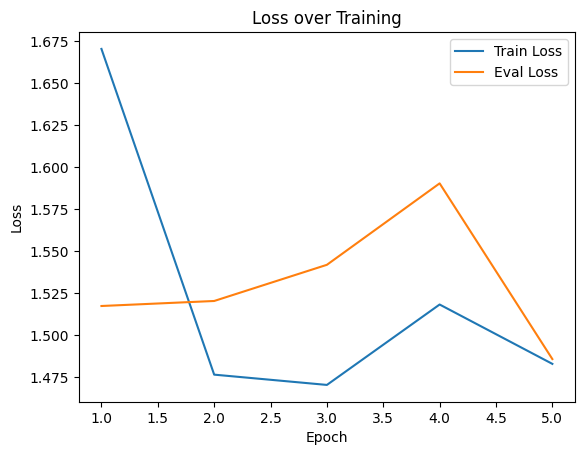

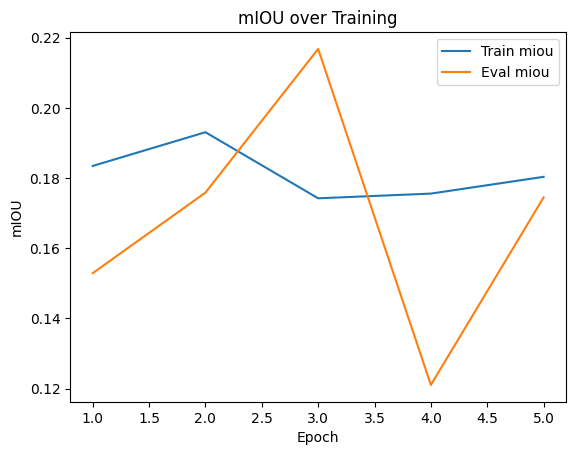

In [30]:
# Plot miou and loss over training model
plt.plot(range(1, num_epochs+1), train_loss_values, label='Train Loss')
plt.plot(range(1, num_epochs+1), eval_loss_values, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Training')
plt.legend()
plt.show()

plt.plot(range(1, num_epochs+1), train_miou_values2, label='Train miou')
plt.plot(range(1, num_epochs+1), eval_miou_values2, label='Eval miou')
plt.xlabel('Epoch')
plt.ylabel('mIOU')
plt.title('mIOU over Training')
plt.legend()
plt.show()

##Test model

In [462]:
#Predict mask of test images with trained model and calculate miou between test ground truth and model prediction mask
model.eval()
test_miou = 0

test_iamges = []
pre_mask= []
g_t_mask = []


with torch.no_grad():
    for images, masks in tqdm(test_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.permute(0, 3, 1, 2)


        outputs = model(images)


        test_miou += calculate_miou(outputs, masks)

        test_iamges.append(images)
        pre_mask.append(outputs)
        g_t_mask.append(masks)






    test_miou /= len(test_dataloader)


print("miou for test data set:",test_miou)

100%|██████████| 1/1 [01:41<00:00, 101.64s/it]


miou for test data set: tensor(0.1260, device='cuda:0')


In [465]:
random_nums = []
for i in range(0,10):
  random_num = random.randint(0,len(test_images))
  while random_num in random_nums:
    random_num = random.randint(0,len(test_images))
  random_nums.append(random_num)

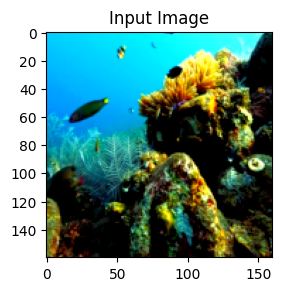

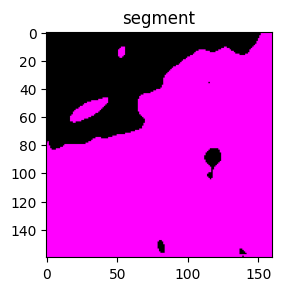

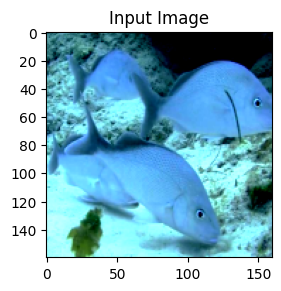

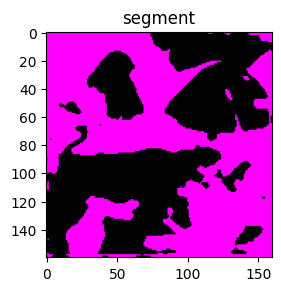

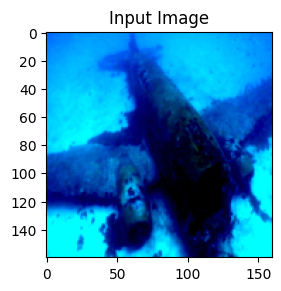

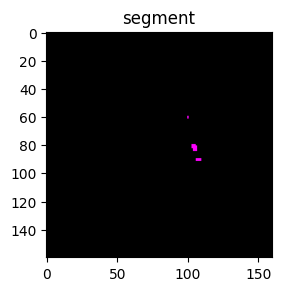

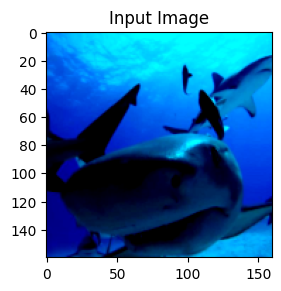

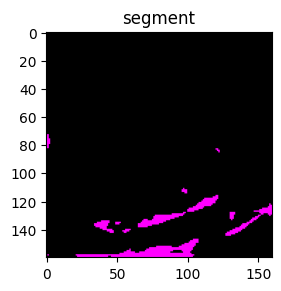

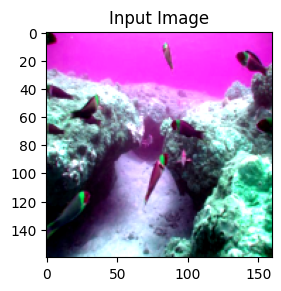

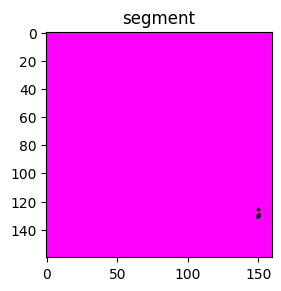

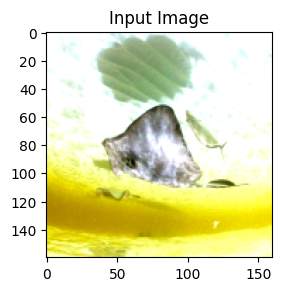

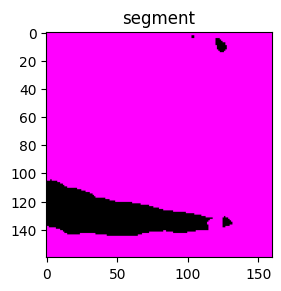

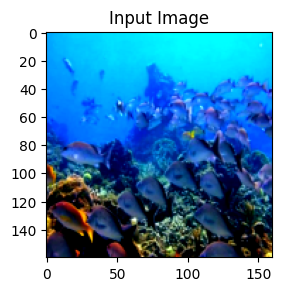

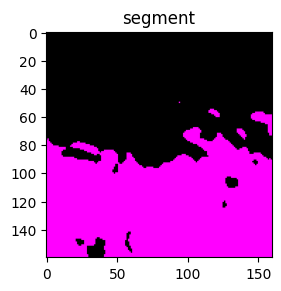

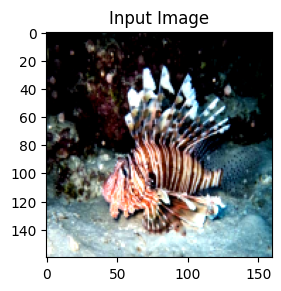

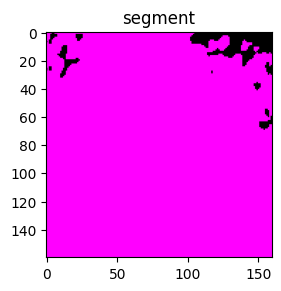

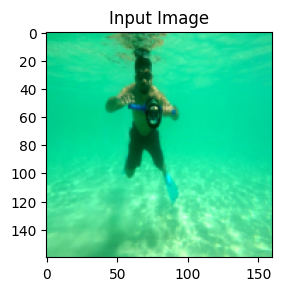

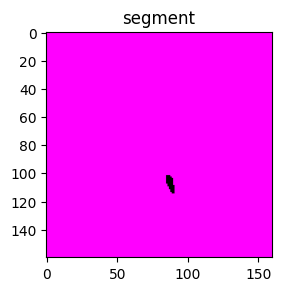

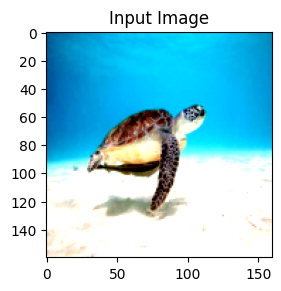

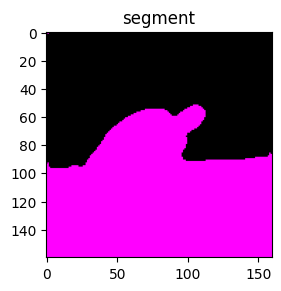

In [468]:
for i in random_nums:
  main_image = test_iamges[0][i]
  main_mask = g_t_mask[0][i]
  model_mask = pre_mask[0][i]

  main_image = main_image.cpu()
  model_mask = model_mask.cpu()

  #### Show image

  image = main_image.permute(1, 2, 0)
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title('Input Image')



  max_values, _ = torch.max(model_mask, dim=0)
  model_mask3 = torch.eq(model_mask, max_values).float()
  colored_image = np.zeros((160, 160, 3), dtype=np.uint8)
  LABEL_COLORS_LIST = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0), (255, 255, 255)]
  for i in range(0,8):
    for j in range(0,160):
      for k in range(0,160):
        if model_mask3[i][j][k] ==1:
          colored_image[j][k] = LABEL_COLORS_LIST[i]

  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(colored_image)
  plt.title('segment')


  plt.show()



